### Capstone Milestone Report

# Ontario Energy Use: Predicting demand from weather and population data

### * James Parks *

# 1. Introduction - The Problem

Ontarians use more than 140 million megawatt hours of electricity a year to run their homes, businesses, hospitals, schools, transit and infrastructure. Ensuring there is enough energy to meet Ontario’s needs 24 hours a day, 7 days a week, requires the close co-ordination of the many moving and integrated parts of the electricity system. 

We know that price and supply can play a large role in demand for a product and that includes energy. It’s clear that weather and population play a huge influence in the demand for energy as well. In order to meet client demands for electricity, energy companies need a robust model. More energy is typically demanded during the day than at night when people are sleeping, but since the change in weather can also affect changes in demand for energy, companies need to be able to anticipate large spikes in demand in order to prevent blackouts.

Planning is essential to a reliable, sustainable electricity future. The IESO plans and prepares for Ontario's electricity needs by assessing electricity requirements for the power system of today and tomorrow as well as planning to ensure electricity will be available when and where it is needed.

The IESO continually produces forecasts of expected demand and available generation, for weeks and days ahead, which take into account: the day of the week, detailed weather forecasts, historical demand, embedded (or distribution-connected) generation, system conditions and special events or holidays.

In this project we look at the historical hourly energy demand of Ontario, Canada from January 1994 until August 2017, the historical energy price, the historical population as well as the historical hourly weather data for Toronto from the same time period.

**The Goal**: Develop a model that predicts energy demand based on weather, price and population data. 

# The Client

The Independent Electricity System Operator (IESO) works at the heart of Ontario's power system as the system operator—directing the flow of electricity across the grid and administering the wholesale electricity market. It sets the hourly Ontario electricity price and ensures there is enough power to meet the province's energy needs in real time. The IESO works with stakeholders and communities across the province to plan and secure energy for the future, as well as guide the conservation efforts in Ontario. 

The client in this case is the IESO, connecting generators and suppliers that sell electricity and wholesale consumers who purchase it. Ontario’s real-time electricity market is a 24/7 operation, with the intersection between offers to supply electricity and bids to consume setting a wholesale price every five minutes.. Having a more robust model for determining just how much changes in weather affect energy demand can be extremely beneficial in saving money and preventing blackouts. Based on this analysis they will be better able to adjust supply to meet expected demands with the changes of seasonal weather. 

Note that although this data is only for Ontario, the analysis may also be of benefit to other regions with similar weather patterns and populations.

# 2. Imports

In [1]:
#Usual imports
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Don't display warning messages
import warnings
warnings.filterwarnings('ignore')

# 3. The Data

The Data comes from three sources.

- Independent Electricity System Operator, http://www.ieso.ca/power-data which has .csv files for the hourly energy demand for the province of Ontario from January 1994 to August 2017, hourly price from 2002 to 2017 and hourly import and export data.
  
- Environment Canada, which has .csv files for the hourly weather data for many locations in Ontario for the same time period. To start with we choose the data for Toronto, since its urban area accounts for a large percentage of the population of Ontario and we make the assumption that its energy demand will contribute to the largest demand in the province.

- Wikipedia, which has the population data for Ontario and Toronto for the years 1996, 2001, 2006, 2011 and 2016. We will use linear interpolation to estimate the approximate population for the intermediate time periods.

## First we import the energy, price and import/export hourly data

In [2]:
#Import the energy data
energy_data_old=pd.read_csv("data\HourlyDemands_1994-2002.csv")
energy_data_recent=pd.read_csv("data\HourlyDemands_2002-2016.csv")
energy_data_this_year=pd.read_csv("data\HourlyDemands.csv")

In [3]:
# Create common columns for all three dataframes
energy_data_old=energy_data_old.rename(columns={'OntarioDemand': 'Ontario Demand'})
energy_data_old['Date']= pd.DatetimeIndex(energy_data_old['DateTime']).date
energy_data_old['Hour']= pd.DatetimeIndex(energy_data_old['DateTime']).hour
energy_data_recent['Date']= pd.DatetimeIndex(energy_data_recent['Date']).date
energy_data_this_year['Date']= pd.DatetimeIndex(energy_data_this_year['Date']).date

In [4]:
#Import the price and import/export data
price_data_this_year=pd.read_csv("data\HOEP.csv")
price_data_past= pd.read_csv("data\HOEP_2002-2016.csv")
imports_this_year=pd.read_csv("data\HourlyImportExportSchedules.csv")
imports_past=pd.read_csv("data\HourlyImportExportSchedules_2002-2016.csv")
# Convert Date columns to datetime 
price_data_this_year['Date']= pd.DatetimeIndex(price_data_this_year['Date']).date
price_data_past['Date']= pd.DatetimeIndex(price_data_past['Date']).date
imports_this_year['Date']= pd.DatetimeIndex(imports_this_year['Date']).date
imports_past['Date']= pd.DatetimeIndex(imports_past['Date']).date

In [5]:
# Join price and imports/exports dataframes together
price_all=pd.concat([price_data_this_year,price_data_past])
imports_all=pd.concat([imports_this_year,imports_past])
price_import=price_all.merge(imports_all,left_on=["Date","Hour"],right_on=["Date","Hour"], how="outer")
# Join all three demand dataframes together and create a standard datetime column
energy_data_all=pd.concat([energy_data_old,energy_data_recent,energy_data_this_year])
# Join demand with price and imports/exports data
df_elect=energy_data_all.merge(price_import,left_on=["Date","Hour"],right_on=["Date","Hour"], how="outer")
df_elect["Date/Time"]=pd.to_datetime(df_elect.Date) + df_elect.Hour.astype('timedelta64[h]')

In [6]:
df_elect_all=df_elect.sort_values(by=["Date/Time"]).drop("DateTime",axis=1)
df_elect_all.tail(10)

,Date,Hour,Ontario Demand,Total Market Demand,HOEP,Imports,Exports,Date/Time
206918,2017-09-09,15,12407,14723.0,2.19,213,"2,384",2017-09-09 15:00:00
206919,2017-09-09,16,12714,14808.0,6.67,216,"2,161",2017-09-09 16:00:00
206920,2017-09-09,17,13103,14988.0,9.64,194,"1,941",2017-09-09 17:00:00
206921,2017-09-09,18,13483,15300.0,11.37,165,"1,869",2017-09-09 18:00:00
206922,2017-09-09,19,13862,15667.0,12.55,607,"1,871",2017-09-09 19:00:00
206923,2017-09-09,20,14116,15614.0,10.34,591,"1,525",2017-09-09 20:00:00
206924,2017-09-09,21,13475,14998.0,5.42,636,"1,544",2017-09-09 21:00:00
206925,2017-09-09,22,12724,14558.0,6.52,247,"1,857",2017-09-09 22:00:00
206926,2017-09-09,23,11912,14077.0,9.62,212,"2,208",2017-09-09 23:00:00
206927,2017-09-09,24,11311,13375.0,2.04,170,"2,082",2017-09-10 00:00:00


## Import the weather data

In [7]:
# We make a single dataframe from all the csv files in the csv folder
path = "./csv/"
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
weather_data=pd.DataFrame()
for f in files_csv:
    data = pd.read_csv(path+f,skiprows=16)
    weather_data = weather_data.append(data)

In [8]:
weather_data.head(4)

,Date/Time,Year,Month,Day,Time,Data Quality,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2002-10-01 00:00,2002,10,1,00:00,,19.5,NaN,16.9,NaN,...,M,NaN,M,100.18,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-10-01 01:00,2002,10,1,01:00,,19.2,NaN,17.2,NaN,...,M,NaN,M,100.19,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-10-01 02:00,2002,10,1,02:00,,19.1,NaN,17.3,NaN,...,M,NaN,M,100.17,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-10-01 03:00,2002,10,1,03:00,,19.2,NaN,17.2,NaN,...,M,NaN,M,100.14,NaN,NaN,NaN,NaN,NaN,NaN


## Import the population data

Note that this data comes from Wikipedia, but only contains population data for the years 1996, 2001, 2006, 2011 and 2016. We will use interpolation to estimate the populations for the years between.

In [9]:
pop_data=pd.read_excel("ontario_pop.xlsx")
# Convert Date column to datetime
pop_data["Date"]=pd.to_datetime(pop_data.Date)
# create a datetime column for the years between 1994 and 2017
date_index = pd.DataFrame({"Date/Time":pd.date_range('1/1/1994', periods=len(weather_data), freq='H')})
# Merge date_index dataframe with the the population data dataframe
pop_merged=date_index.merge(pop_data,left_on="Date/Time",right_on="Date",how="outer")
# Subset on useful columns
pop_merged=pop_merged[["Date/Time", "Ontario_pop","Toronto_pop"]]
# Use linear interpolation to estimate the hourly population between offical census data
pop_merged.interpolate(method='linear',limit_direction="both",inplace=True)
# Round population estimates to the nearest integer
pop_merged[["Ontario_pop","Toronto_pop"]]=pop_merged[["Ontario_pop","Toronto_pop"]].round()

In [10]:
# We merge the electricity and weather dataframes together
weather_data["Date/Time"]=pd.to_datetime(weather_data["Date/Time"])
weather_merge=pd.merge(weather_data,df_elect_all, how="outer",left_on="Date/Time",right_on="Date/Time")
# Now merge with the populaton dataframes
all_data=pd.merge(weather_merge,pop_merged, how="outer",left_on="Date/Time",right_on="Date/Time")

In [11]:
# Convert Import and Export columns to numerical
all_data["Imports"]=all_data.Imports.replace({",":""}, regex=True)
all_data["Imports"]=pd.to_numeric(all_data.Imports, errors='coerce')
all_data["Exports"]=all_data.Exports.replace({",":""}, regex=True)
all_data["Exports"]=pd.to_numeric(all_data.Exports, errors='coerce')

In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207673 entries, 0 to 207672
Data columns (total 34 columns):
Date/Time              207673 non-null datetime64[ns]
Year                   207456 non-null float64
Month                  207456 non-null float64
Day                    207456 non-null float64
Time                   207456 non-null object
Data Quality           205294 non-null object
Temp (°C)              205284 non-null float64
Temp Flag              10 non-null object
Dew Point Temp (°C)    205284 non-null float64
Dew Point Temp Flag    10 non-null object
Rel Hum (%)            205284 non-null float64
Rel Hum Flag           10 non-null object
Wind Dir (10s deg)     69305 non-null float64
Wind Dir Flag          130567 non-null object
Wind Spd (km/h)        75005 non-null float64
Wind Spd Flag          130618 non-null object
Visibility (km)        73619 non-null float64
Visibility Flag        21006 non-null object
Stn Press (kPa)        199629 non-null float64
Stn Press Fla

## Investigate missing Ontario Demand data

In [13]:
print(all_data[all_data["Ontario Demand"].isnull()]["Date/Time"].head(3))
all_data[all_data["Ontario Demand"].isnull()]["Date/Time"].tail(3)

197280   2001-12-01 00:00:00
197281   2001-12-01 01:00:00
197282   2001-12-01 02:00:00
Name: Date/Time, dtype: datetime64[ns]


198022   2001-12-31 22:00:00
198023   2001-12-31 23:00:00
206712   2002-05-01 00:00:00
Name: Date/Time, dtype: datetime64[ns]

We find see that we are missing the Ontario energy demand for the whole month of December in 2001 as well as for midnight May 5, 2002, which was when the market first came online.

For the month of December we replace the missing data we use linear approximation in intervals of 24 hours to approximate the demand for January of 2002 and for the energy demand for May 5,2002 we use the previous day's demand.

In [14]:
# We calculate the average increase in Ontario demand over the missing month.
print((all_data.iloc[198024,27]-all_data.iloc[197279,27])/31)

22.7096774194


In [15]:
#List the indices where the Ontario Demand data is missing.
en_list_df=all_data[197280:198024].index
# Replace the missing demand with the previous day's energy demand increased by the average daily increase.
for i in en_list_df:
    all_data.iloc[i,27]=all_data.iloc[i-24,27]+22.709677

# Replace themissing May 2002 data with the previous day's demand
all_data.iloc[206712,27]=all_data.iloc[206712-24,27]

## Weather and Population Variable Descriptions

** Date/Time:** Date and Time given in local Eastern Time.

** Data Quality: ** Is either ' ' if there is no problems with the data quality or nan if the weather data is missing.

** Temp (°C): ** The hourly temperature give in celsius.

** Temp Flag, Dew Point Temp Flag, Rel Hum Flag, Wind Dir Flag, Visibility Flag, Stn Press Flag, Hmdx Flag or Wind Chill Flag: ** Is either 'M' or nan if the corresponding feature is missing.

** Dew Point Temp (°C): ** is the temperature to which air must be cooled to become saturated with water vapor. A high relative humidity implies that the dew point is closer to the current air temperature.

** Rel Hum (%): ** is the ratio of the partial pressure of water vapor to the equilibrium vapor pressure of water at a given temperature. It requires less water vapor to attain high relative humidity at low temperatures; more water vapour is required to attain high relative humidity in warm or hot air.

** Wind Dir (10s deg): ** is the direction from which the wind originates. It is measured on a scale of 0 to 360° in 10 degree increments. Here North is between 35. and 1. 

** Wind Spd (km/h): ** is the wind speed given in kilometers / hour.       75005 non-null float64

** Wind Spd Flag: ** Is either 'M' or nan if the corresponding feature is missing or 'E' if the speed is given, but not the direction.

** Visibility (km): ** is a measure of the distance at which an object or light can be clearly discerned, given in kilometers.

** Stn Press (kPa): ** is the atmospheric pressure given in kiloPascals.

** Hmdx: ** is an index number used by Canadian meteorologists to describe how hot the weather feels to the average person, by combining the effect of heat and humidity. A formula for Hmdx based on the dew point temperature is given in a later section.

** Wind Chill: ** is the perceived decrease in air temperature felt by the body on exposed skin due to the flow of air.
Wind chill numbers are always lower than the air temperature for values where the formula is valid.

** Weather: ** describes the type of weather. (E.g. rainy, snowy, sunny, cloudy etc.)

** Ontario_pop: ** Estimated population of Ontario for that hour.

** Toronto_pop: ** Estimated population of Toronto for that hour.



## Energy Demand and Price Variable Descriptions

The IESO accepts the lowest-cost offers to supply electricity until sufficient megawatts are available to meet Ontario’s demand. The IESO then dispatches generators and importers to provide electricity based on their accepted offers. Some types of generators are more expensive to operate than others − as a result, the wholesale price of electricity rises as more expensive forms of generation are brought online to meet demand. A new market clearing price for electricity is set every five minutes.

** Ontario Demand: ** The amount of power measured in Megawatts consumed throughout Ontario for that hour. Total Ontario electricity demand is calculated as: 

$$\text{Total Energy }+\text{ Total Generation Without Offers }-\text{ Total Exports }+\text{ Total Off Market }+/- \text{ Over/Under Generation}.$$ 
where
- *Total Energy* is the total energy dispatched into the IESO controlled grid, calculated as Ontario generation plus imports.
- *Total Generation Without Offers* is the total energy injected into the IESO controlled grid from generators that have not submitted offers.
- *Total Exports* is the total energy dispatched outside Ontario from the IESO controlled grid.
- *Total Off Market* consists of transactions related to Segregated Mode of Operation, Emergency, Simultaneous Activation of Reserve and Inadvertent Interchange.  
- *Over/Under Generation* is the total energy resulting from over or under generation in the event of differences when the Dispatch Scheduling and Optimization (DSO) tool is balancing supply and demand.

** Total Market Demand: ** is given by Total Energy + Total Generation Without Offers described above. 

** Imports: ** is the total energy injected into the IESO controlled grid from generators outside Ontario.

** Exports: ** is given by Total exports as described above.

** HOEP: ** is the hourly Ontario wholesale energy market price given in ($/MWh). A Megawatt hour is the amount of power consumed measured in Megawatts in one hour. The average of the twelve market clearing prices set in each hour is called the Hourly Ontario Energy Price, or HOEP. The HOEP is charged to large consumers that participate in the market, as well as local distribution companies (LDCs) who in turn recover it from business customers that pay the wholesale market price.

The wholesale market price represents the cost of producing electricity in real time, based on changing supply and demand. The price does not include the cost of transporting electricity across the province or longer-term fixed costs such as building and financing grid infrastructure. These costs are recovered outside of the wholesale electricity market.





# 4. Exploratory Data Analysis

## Investigate monthly temperature average

In [16]:
yearly_avg=all_data.groupby(["Year","Month"]).mean().reset_index()
yearly_avg["year/month"]=pd.to_datetime(yearly_avg[["Year","Month","Day"]])

In [17]:
def line_plot(df,ind,dep,label_name,title_name,plot_color):
    fig,ax = plt.subplots(figsize=(12,9))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.plot(df[ind], df[dep], color=plot_color, linewidth=0.8,label=label_name)
    plt.xlabel(ind, fontsize=12)
    plt.ylabel(dep, fontsize=12)
    plt.title(title_name, fontsize=14)
    plt.legend()
    plt.show()

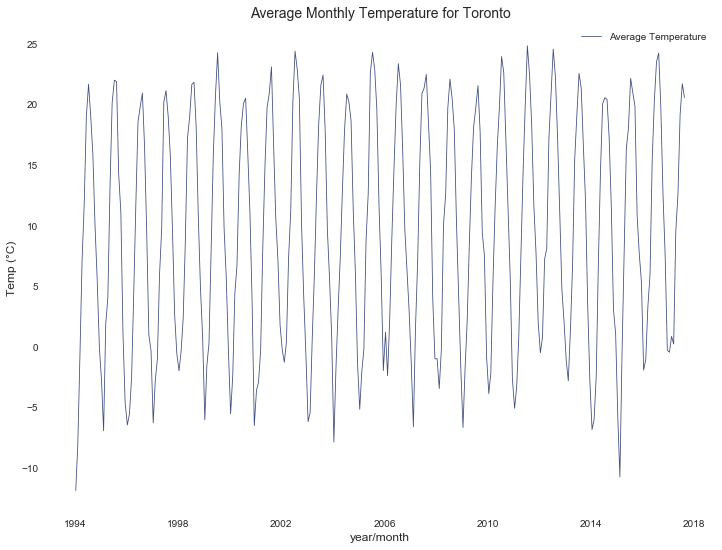

In [18]:
line_plot(yearly_avg,"year/month","Temp (°C)", "Average Temperature",'Average Monthly Temperature for Toronto',"#3F4D7D")

Here we see that monthly average temperatures have not changed too dramatically over the years. The winters of 2014 and especially 2015 look to be outliers in the recent trend of warmer winters of the past six years. The summers seem to have an average temperature between 20°C and 25°C.

## Investigate average monthly energy demand

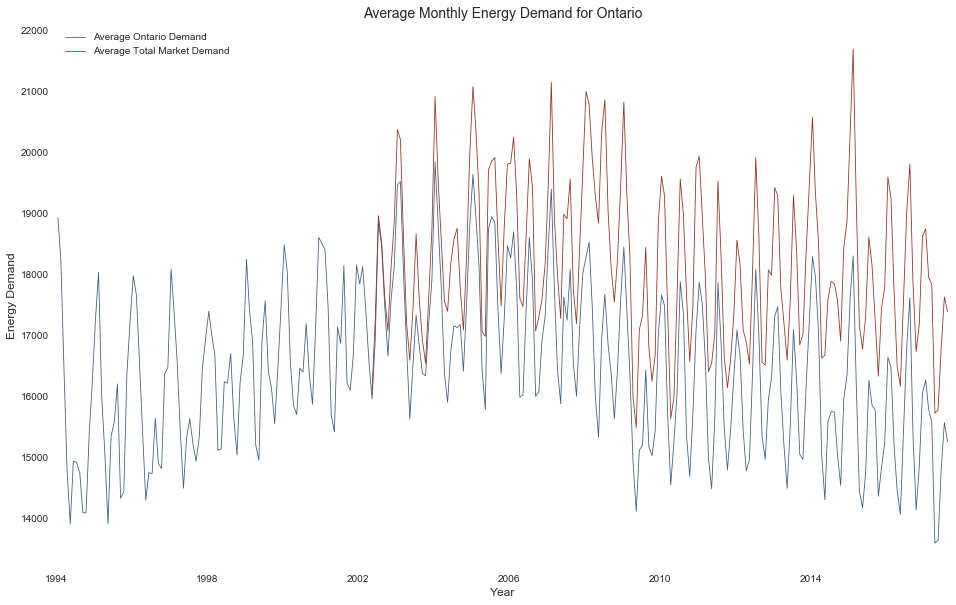

In [19]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(yearly_avg["year/month"], yearly_avg["Ontario Demand"], color="#3F5D7D", linewidth=0.8,label="Average Ontario Demand")
plt.plot(yearly_avg["year/month"], yearly_avg["Total Market Demand"], color="#8E3320", linewidth=0.8,label="Average Total Market Demand")
plt.xlabel('Year', fontsize=12)
plt.ylabel('Energy Demand', fontsize=12)
plt.title('Average Monthly Energy Demand for Ontario', fontsize=14)
plt.xlim(["1994-01-01","2017-08-31"])
plt.legend()
plt.show()

The IESO opened the Ontario electricity market on May 1st 2002. Afterwards there is both electricity demanded by Ontario as well as the Total Demand which also included energy exported to other regions. 

If we look only at the Ontario energy demand we see that demand has been decreasing since the market opened even though the population has been increasing, which could be a result of higher prices to consumers or improvements in energy efficiency.  The IESO report that coal-fired generation has been phased out; wind and solar generation have joined the provincial supply mix; and new types of demand response and storage resources are also helping to meet the province's demand for electricity. Furthermore, we see that the exports seem to be increasing as well.

The drop in demand in 2009 could be a result of the recession. The weather could have been milder that year as well. The big spike in demand at the beginning of 2015 is almost certainly a result of the abnormally cold winter that year.

## Investigate average monthly exports

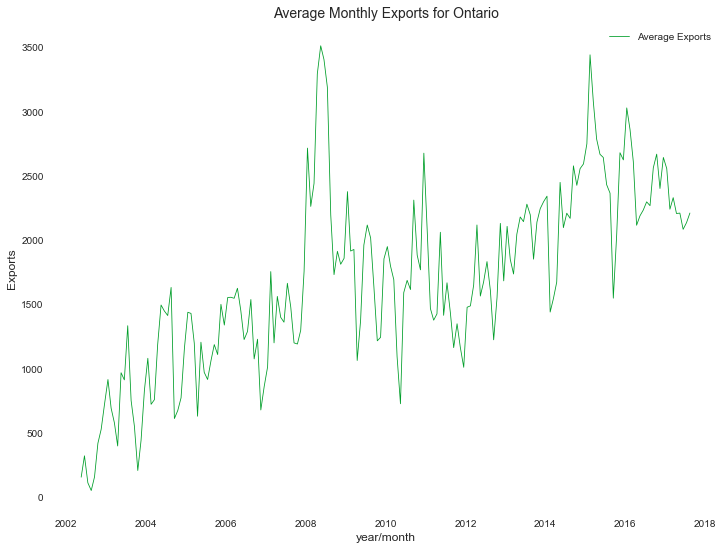

In [20]:
line_plot(yearly_avg,"year/month","Exports", "Average Exports",'Average Monthly Exports for Ontario',"#009e29")

Ontario has slowly been exporting more energy overtime with two big spikes, one in the beginning of 2008, which corresponded to a dramatic increase in oil prices and one in the winter of 2015.

## Investigate average monthly price

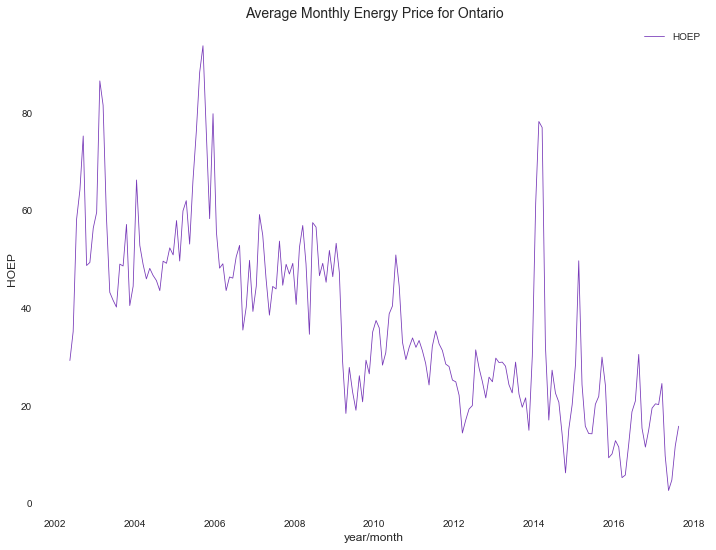

In [21]:
line_plot(yearly_avg,"year/month","HOEP", "HOEP",'Average Monthly Energy Price for Ontario', "#7739b8")

We see a general trend of decreasing average energy price, with a few very big spikes in 2005, 2014 and to a lesser extent in 2003 and 2015.

In [22]:
all_data.drop(["Year","Month","Day","Hour", "Hmdx Flag","Wind Chill Flag"],axis=1).describe()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Ontario Demand,Total Market Demand,HOEP,Imports,Exports,Ontario_pop,Toronto_pop
count,205284.000000,205284.000000,205284.000000,69305.000000,75005.000000,73619.000000,199629.000000,32838.000000,16589.000000,207673.000000,134664.000000,134664.000000,134664.000000,134664.000000,2.074560e+05,2.074560e+05
mean,9.348264,3.801280,70.485518,22.444499,14.913232,21.264546,99.962070,29.852001,-11.868346,16445.103466,18196.415872,37.253889,819.498775,1684.291355,1.210313e+07,5.533069e+06
std,10.670415,10.206349,16.406300,9.895402,9.836360,9.570469,0.842069,3.807568,6.391140,2570.270868,2530.421406,34.864035,597.706193,876.115161,9.342699e+05,6.227322e+05
min,-30.300000,-36.100000,9.000000,1.000000,0.000000,0.000000,96.550000,25.000000,-40.000000,2270.000000,2270.000000,-138.790000,0.000000,0.000000,1.049127e+07,4.447904e+06
25%,1.300000,-3.600000,60.000000,14.000000,7.000000,16.100000,99.430000,27.000000,-16.000000,14521.000000,16306.000000,19.950000,330.000000,1058.000000,1.126775e+07,4.983648e+06
50%,9.500000,3.900000,72.000000,25.000000,13.000000,24.100000,99.980000,29.000000,-11.000000,16430.000000,18119.000000,32.100000,726.000000,1679.000000,1.213521e+07,5.540070e+06
75%,18.300000,12.300000,83.000000,31.000000,20.000000,25.000000,100.520000,32.000000,-7.000000,18234.000000,19880.000000,45.780000,1213.000000,2276.000000,1.294134e+07,6.108703e+06
max,37.400000,26.700000,100.000000,36.000000,76.000000,40.200000,102.980000,51.000000,-1.000000,27005.000000,27999.000000,1891.140000,4571.000000,5571.000000,1.364728e+07,6.538558e+06


Some interesting things to note is that the average temperature of Toronto is 9.5 °C and the average Pressure is 99.8 kPa, well below the standard temperature and pressure. Ontario Demand seems centered around 16430 MW with a ver low minimum and rather high maximum. These are possible outliers that we will investigate later. HOEP can lso be negative, which can occur when there is more energy being produced than expected and customers are being reimbursed for using energy. Also, the maximum HOEP looks rather high as well.

## Relationships between the various features

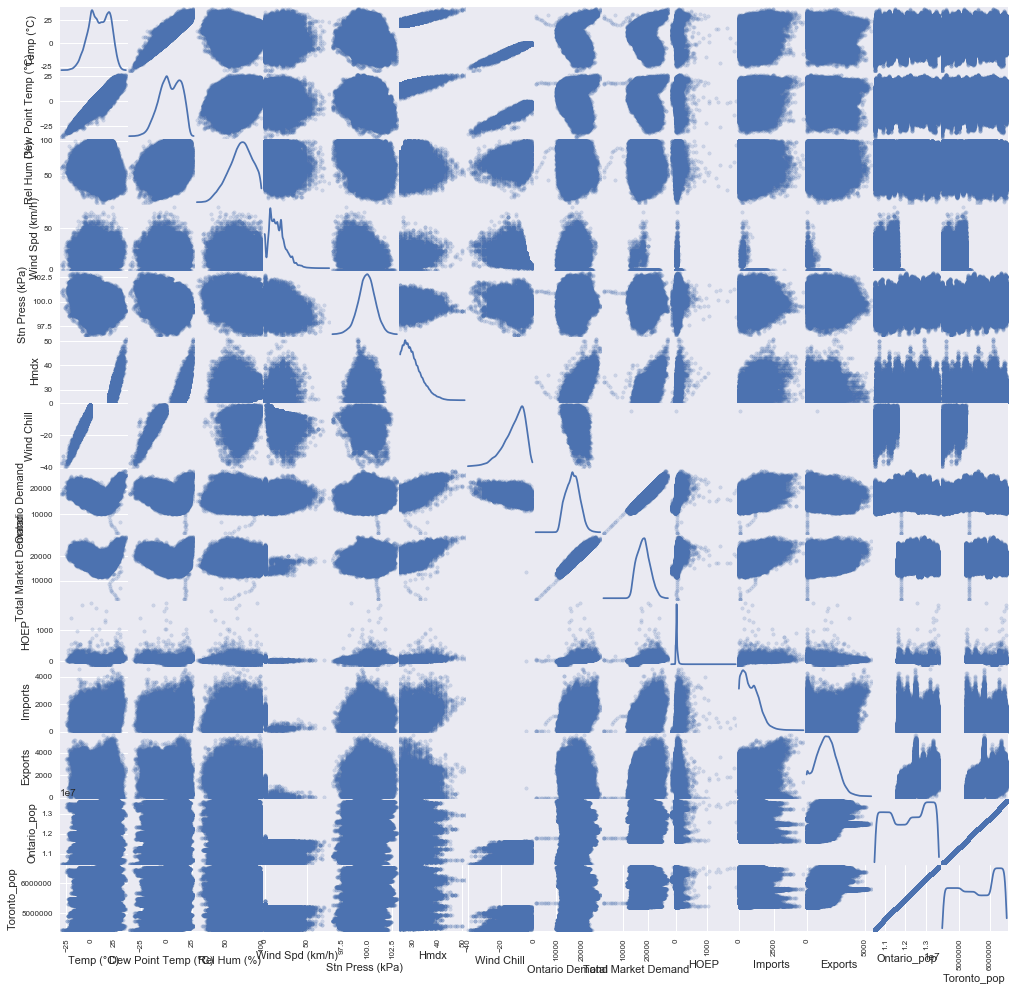

In [23]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(all_data.drop(["Year","Month","Day","Wind Dir (10s deg)","Visibility (km)","Hmdx Flag","Wind Chill Flag","Hour"],axis=1),alpha=0.2, figsize=(17, 17), diagonal='kde')
plt.show()

Most of the variables are normally distributed. We see some suspicious outliers in the energy demand vs temperature and energy demand vs humidex scatter plots. Otherwise there is a very strong correlation between humidex and energy demand and energy demand and a non-linear relationship between temperature and energy demand. The non-linear nature is due to the large demand for heat when the temperature is very low and the large demand for cooling when the temperature is very high.

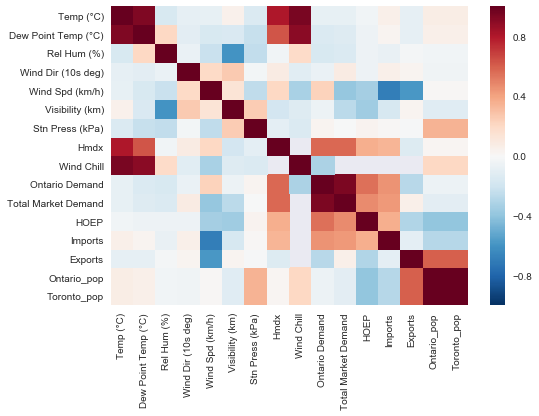

In [24]:
corr = all_data.drop(["Year","Month","Day","Hmdx Flag","Wind Chill Flag","Hour"],axis=1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

Here we see a strong positive correlation between humidex and energy demand as well as a subtle inverse relationship between demand and wind chill.Price and Imports also seem to have a strong positive relationship with demand. This seems to imply that when demand is higher then the price of energy is also higher. Likewise, when imports are high then price is higher and when exports are higher the price is lower. There is also a strong positive relationship between population and exports. Since the population of Ontario has only been growing with time this suggests that more and more energy is being exported every year.

In [25]:
def sc_plot(df,ind,dep, col_code,title_name):
    fig,ax = plt.subplots(figsize=(10, 8))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.scatter(df[ind], df[dep], color=col_code)
    plt.xlabel(ind, fontsize=12)
    plt.ylabel(dep, fontsize=12)
    plt.title(title_name, fontsize=14)
    plt.show()

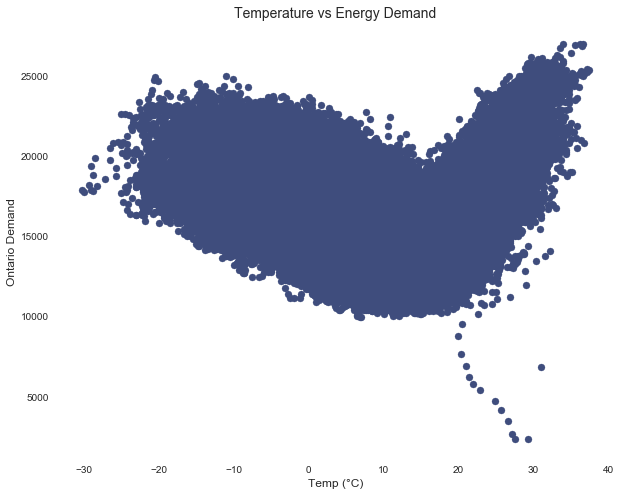

In [26]:
sc_plot(all_data,"Temp (°C)",'Ontario Demand', "#3F4D7D", 'Temperature vs Energy Demand')

There is a very clear distinctive relationship between temperature and energy demand. We see that energy demand increases slowly as temperature decreases from 15°C and increases more rapidly as temperature increases from 15 °C. There are also some clear outliers with very low Ontario Demand.

## Investigate extremely low energy demand hours

In [27]:
# Investigate which dates gave abnormally low values of demand.
low_energy=all_data[all_data["Ontario Demand"]<10000]
low_energy["Date/Time"].unique

<bound method Series.unique of 12760    2003-08-14 16:00:00
12761    2003-08-14 17:00:00
12762    2003-08-14 18:00:00
12763    2003-08-14 19:00:00
12764    2003-08-14 20:00:00
12765    2003-08-14 21:00:00
12766    2003-08-14 22:00:00
12767    2003-08-14 23:00:00
12768    2003-08-15 00:00:00
12769    2003-08-15 01:00:00
12770    2003-08-15 02:00:00
12771    2003-08-15 03:00:00
12772    2003-08-15 04:00:00
12773    2003-08-15 05:00:00
12774    2003-08-15 06:00:00
141843   1994-09-05 03:00:00
141844   1994-09-05 04:00:00
Name: Date/Time, dtype: datetime64[ns]>

On August 14, 2003, Ontario and the northeastern United States experience a large scale blackout. https://en.wikipedia.org/wiki/Northeast_blackout_of_2003 At the time, it was the world's second most widespread blackout in history.

** Note**: When investigating the remaining relationships, we remove the blackout hours from the visualization.

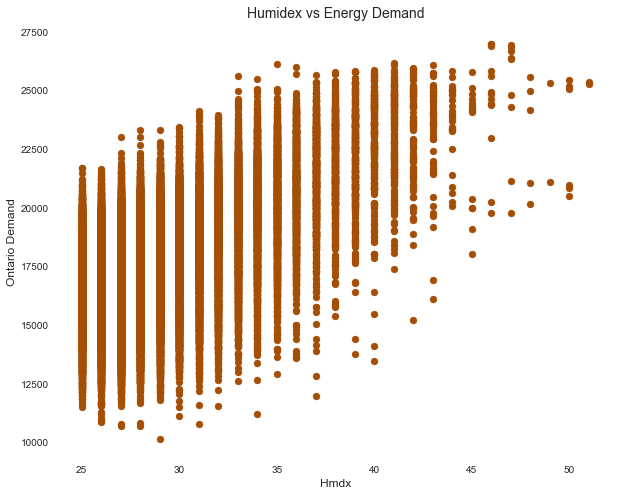

In [28]:
blackout_list=all_data[12760:12775].index
sc_plot(all_data.drop(blackout_list),"Hmdx",'Ontario Demand', '#a54e06', 'Humidex vs Energy Demand')

Here we see a slight postive relationship between Humidex and Energy demand. Since temperature is closely correlated with temperature we removed the blackout hours outliers that were detected above.

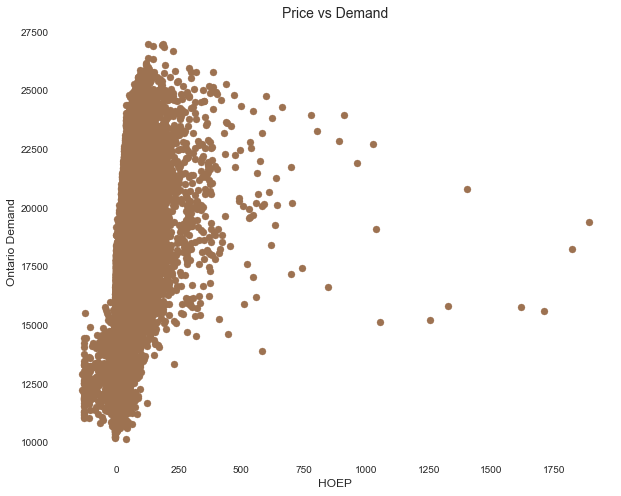

In [29]:
sc_plot(all_data.drop(blackout_list),"HOEP",'Ontario Demand', '#9d7251', 'Price vs Demand')

In this case we see a slight positive relationship between demand and price where when the price increases when the demand is higher although for the most part price changes very little regardless of the demand. Note that there are quite a few outliers with a very high HOEP.

In [30]:
# Investigate which dates gave abnormally high values of price.
high_price=all_data[all_data["HOEP"]>750]
high_price[["Date/Time","Temp (°C)","Ontario Demand","HOEP", "Imports","Exports"]].sort_values(by="HOEP",ascending=False)

,Date/Time,Temp (°C),Ontario Demand,HOEP,Imports,Exports
61116,2009-02-18 12:00:00,1.0,19413.0,1891.14,458.0,581.0
129548,2017-03-11 20:00:00,-8.5,18260.0,1822.95,960.0,2602.0
130304,2017-04-12 08:00:00,6.2,15591.0,1711.03,231.0,1822.0
125156,2016-06-09 20:00:00,16.5,15787.0,1619.60,671.0,1793.0
113744,2015-02-20 08:00:00,-20.7,20807.0,1402.44,344.0,3624.0
125157,2016-06-09 21:00:00,15.2,15826.0,1327.89,700.0,1617.0
115528,2015-05-05 16:00:00,15.2,15238.0,1255.89,1010.0,2067.0
111105,2015-10-02 09:00:00,8.8,15115.0,1053.11,1377.0,1755.0
61115,2009-02-18 11:00:00,1.6,19103.0,1039.27,329.0,1534.0
4478,2002-09-03 14:00:00,30.0,22718.0,1028.42,2329.0,3.0


On initial investigation it doesn't seem like there is anything particularly special about the dates or temperatures when the price was very high. 

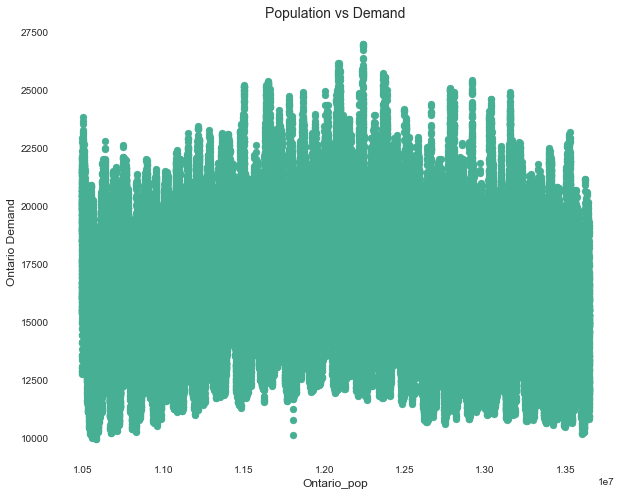

In [31]:
sc_plot(all_data.drop(blackout_list),"Ontario_pop",'Ontario Demand', '#47af94', 'Population vs Demand')

Since population is increasing over time, we see a slightly cyclical pattern to the relationship between demand and population, which was explained in the plot above of average monthly energy demand over time.

## Investigate Trends for different time periods

In [32]:
def bar_plot(df,ind,objects,dep,title_name,plot_color):
    fig,ax = plt.subplots(figsize=(14,8))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, df[dep], color=plot_color, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.xlabel(ind, fontsize=12)
    plt.ylabel(dep, fontsize=12)
    plt.title(title_name, fontsize=14)
    plt.legend()
    plt.show()

### Average Hourly Energy Consumption

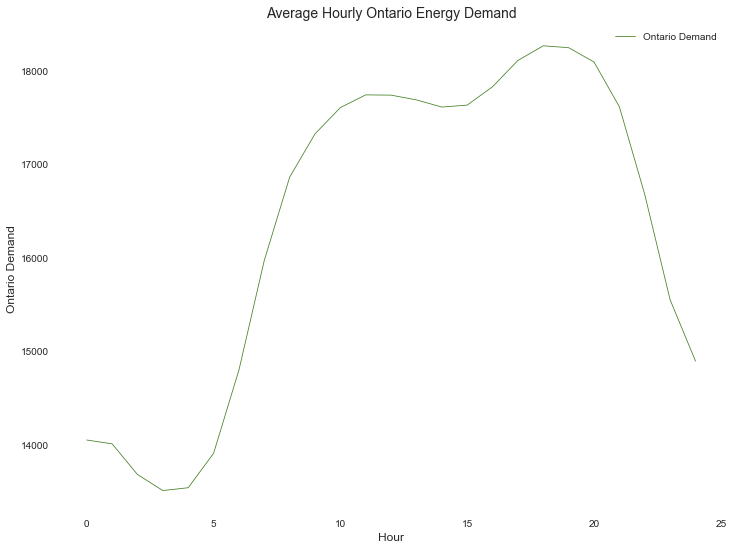

In [33]:
# Let's look at average hourly consumption.
gone=all_data.groupby(["Hour"]).mean().reset_index()
line_plot(gone,"Hour","Ontario Demand", "Ontario Demand",'Average Hourly Ontario Energy Demand','#478329')

Here we see that the demand is lowest on average between 2 and 5 a.m. and then increases rapidly between 5 and 10 as people wake up and go to work. There is a slight decrease from 11 until 3 and then a bigger spike between 16 and 20 when people are generally back at home.

### How does energy demand change throughout the year?

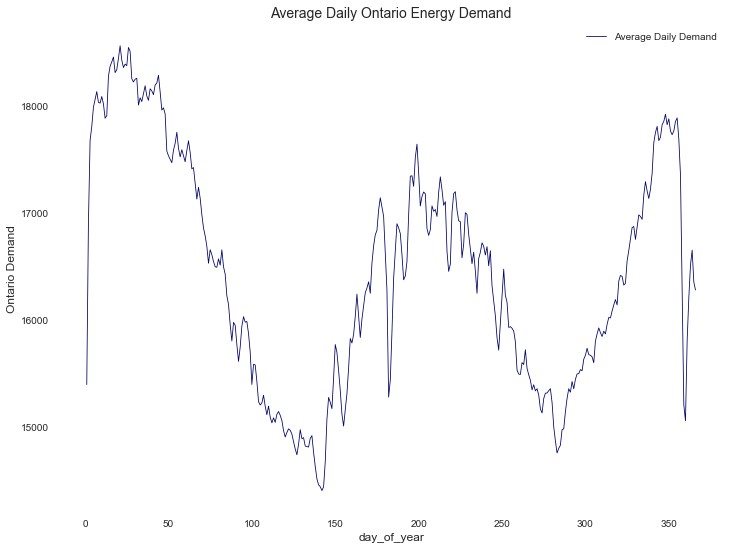

In [34]:
dyear=all_data["Date/Time"].dt.dayofyear
dweek = all_data["Date/Time"].dt.dayofweek
dyear=dyear.rename("day_of_year")
dweek=dweek.rename("day_of_week")
day_data=pd.concat([all_data,dyear,dweek],axis=1)
gtwo=day_data.groupby("day_of_year").mean().reset_index()
line_plot(gtwo,"day_of_year","Ontario Demand", "Average Daily Demand",'Average Daily Ontario Energy Demand', '#000368')

Here we can see that the average energy demand is higher in the winter months and during the summer. In the spring and fall the weather is milder in Ontario so it makes sense that there is less energy demanded for heating and cooling during those months. We see that there are a couple big drops in energy demand. One occurs on the days 182 and 183, which is the holiday Canada Day depending on whether or not the year is a leap year and the other days are 359 and 360, which correspond to Christmas. This makes sense since many businesses are closed on holidays and there is less demand for energy.

### How does energy demand change throughout the week?

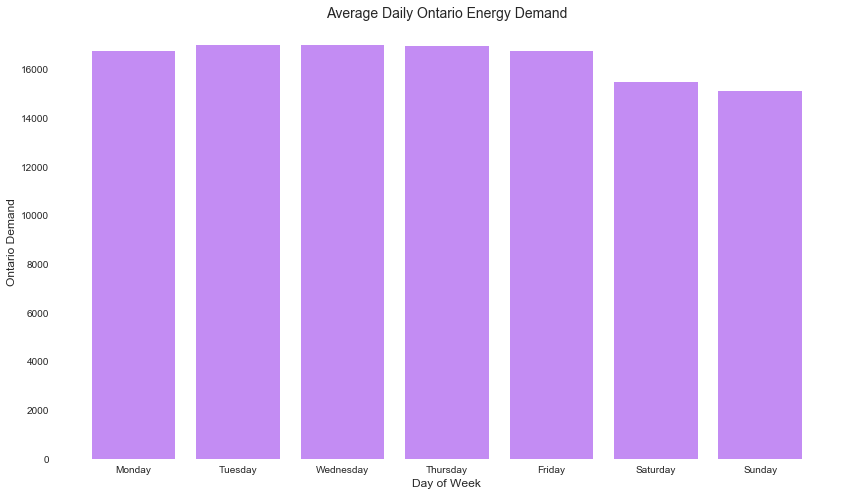

In [35]:
gthree=day_data.groupby("day_of_week").mean().reset_index()
bar_plot(gthree,"Day of Week",["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],"Ontario Demand",'Average Daily Ontario Energy Demand','#881be9')

Demand is clearly less on the weekends than during the week, but also Monday is likely slightly less since many holidays occur on a Monday.

### How has the total energy demanded changed throughout the years?

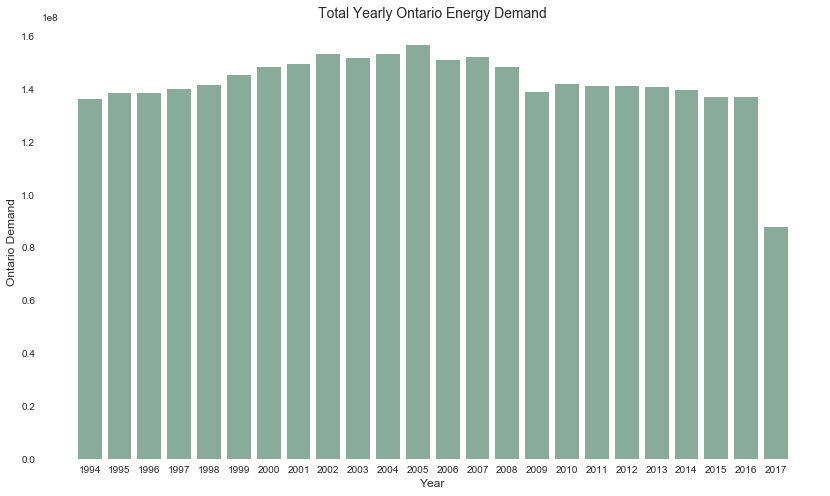

In [36]:
gfour=day_data.groupby("Year").sum().reset_index()
gfour["Year"]=gfour["Year"].astype(int)
bar_plot(gfour,"Year",gfour["Year"],"Ontario Demand",'Total Yearly Ontario Energy Demand','#135938')
gfive=day_data.groupby("Year").mean().reset_index()

Although 2017 is not over so the total energy demand for this year will certainly be less, we do see a slight decrease in energy over the past few years. The other big difference is in the change from 2001 to 2002. 2002 was the first year that energy was traded on the market.

## Investigate large hourly changes in energy demand
We investigate how hourly changes in temperature and price correspond with changes in demand. Does the demand drop or increase? In addition, we look into when the biggest changes occur between hourly energy consumption.

In [37]:
weather_drop=all_data.sort_values(by="Date/Time").drop(["Year","Month","Day","Wind Dir (10s deg)","Visibility (km)","Hmdx Flag","Wind Chill Flag","Hour"],axis=1)
weather_drop["demand_diff"] = weather_drop["Ontario Demand"].diff()
weather_drop["Hourly temperature change"] = weather_drop["Temp (°C)"].diff()
weather_drop["Hourly price change"] = weather_drop["HOEP"].diff()

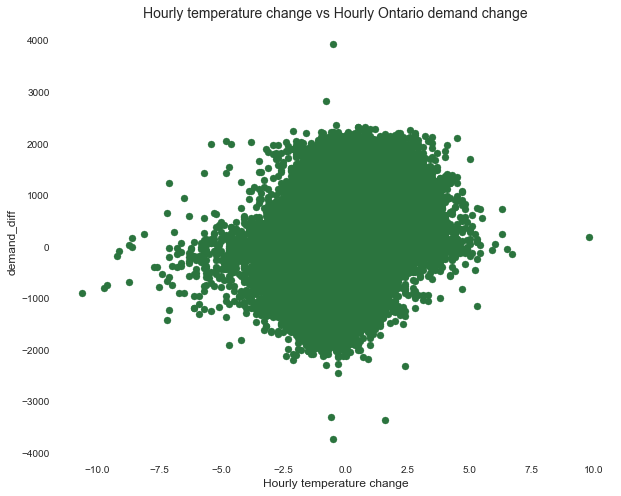

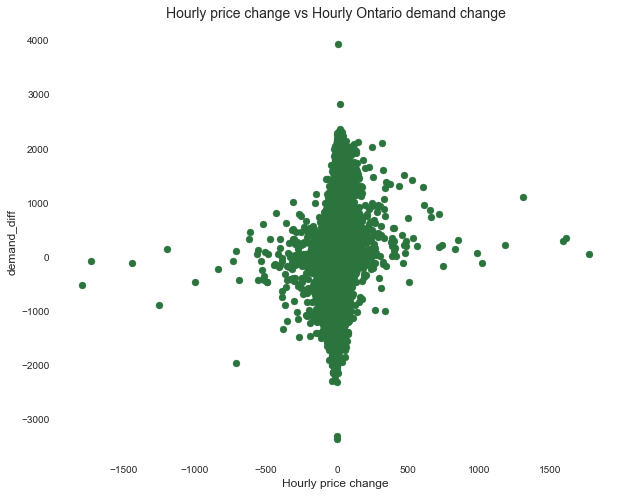

In [38]:
sc_list = ["Hourly temperature change","Hourly price change"]
for diff in sc_list:
    sc_plot(weather_drop.drop(blackout_list),diff,'demand_diff', '#2b743e', diff + ' vs Hourly Ontario demand change')

From this plot, there does not seem to be any clear relationship between hourly temperature change and hourly demand change. Price does not fluctuate as widely as temperature, but there also does not seem to be any clear relationship with demand. Note that the hours with the largest price changes in magnitude did not correspond to similarly large changes in demand.

## Rolling Averages
A simple moving average is customizable in that it can be calculated for a different number of time periods, simply by adding the demand for a number of time periods and then dividing this total by the number of time periods, which gives the average demand over the time period. A simple moving average smooths out volatility, and makes it easier to view the demand trend.

We first calculate the rolling average where the size of the moving window is fixed. We then calculate again using an exponentially-weighted moving average.

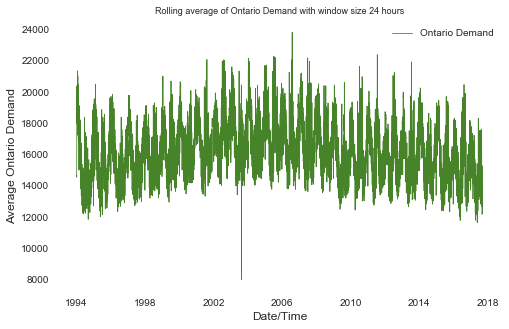

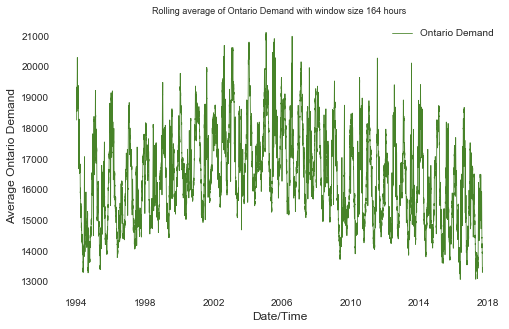

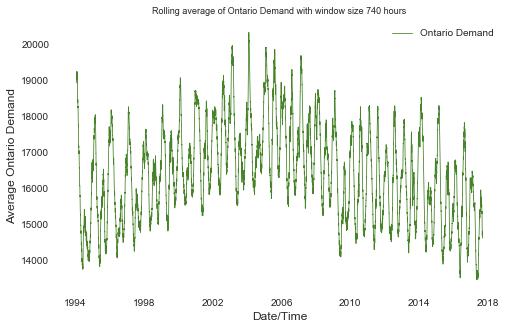

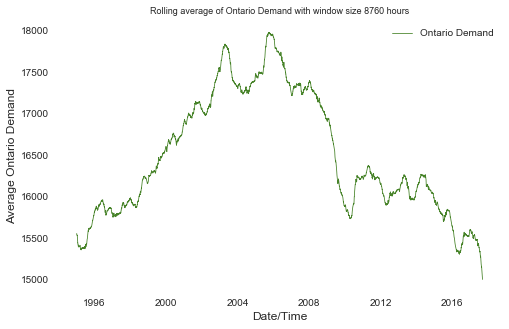

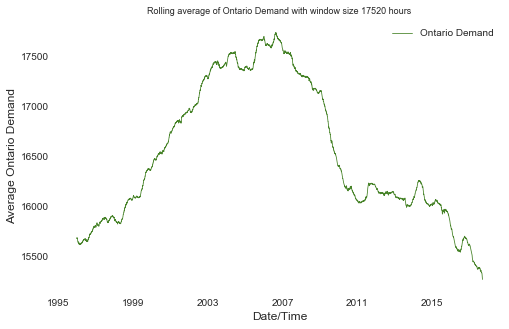

In [39]:
# Subset the dataset and make the Date/Time column the index
df_rolling = all_data[["Date/Time","Ontario Demand"]].sort_values(by="Date/Time").set_index("Date/Time")
# Compute the moving average with different window sizes.
#We pick window sizes of 24, 164, 740, 8760 and 17520, which represent roughly: daily, weekly, monthly, yearly and 
#bi-yearly respectively.
window_sizes = [24,164,740,8760,17520]
# Plot the moving average for each window size.
for win in window_sizes:
    demand_roll=df_rolling.rolling(window = win).mean()
    fig,ax = plt.subplots(figsize=(8,5))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.plot(df_rolling.index, demand_roll, color='#478329', linewidth=0.8,label="Ontario Demand")
    plt.xlabel("Date/Time", fontsize=12)
    plt.ylabel("Average Ontario Demand", fontsize=12)
    plt.title("Rolling average of Ontario Demand with window size "+str(win)+" hours", fontsize=9)
    plt.legend()
    plt.show()

We see that increasing the window size lessens the impact of the blackout. For larger window sizes we see the slow decline in energy demand since 2005 with small changes due to seasonal fluctuations. With a window size of one year, we can see the steep average decline in energy demand since 2007.

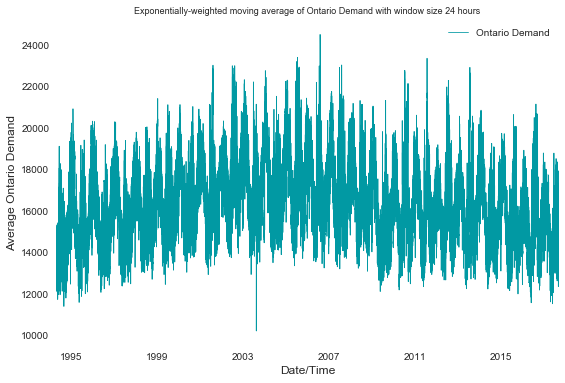

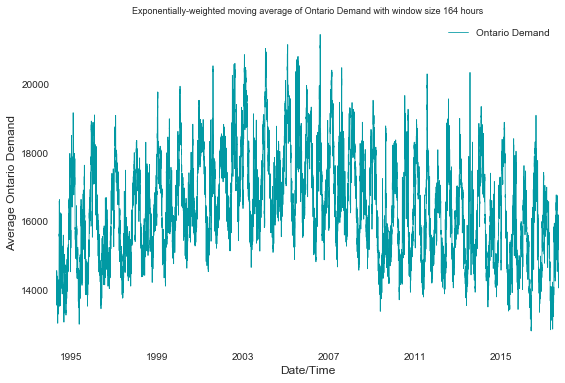

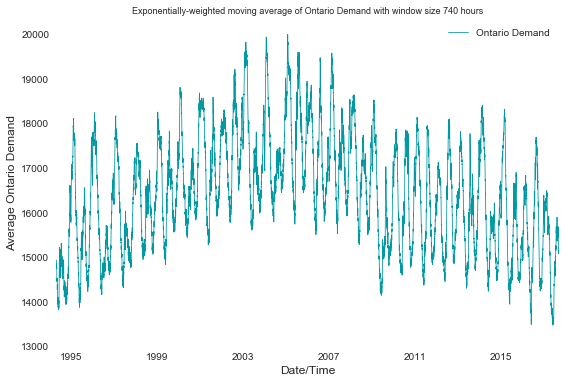

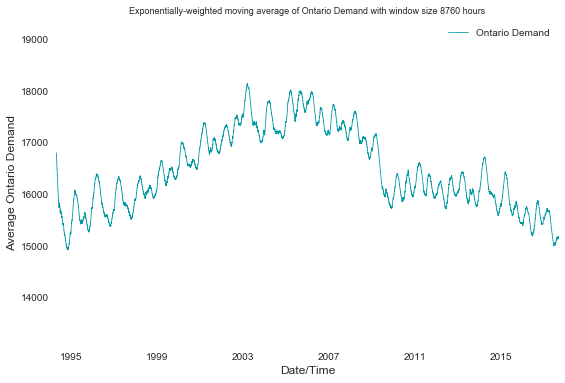

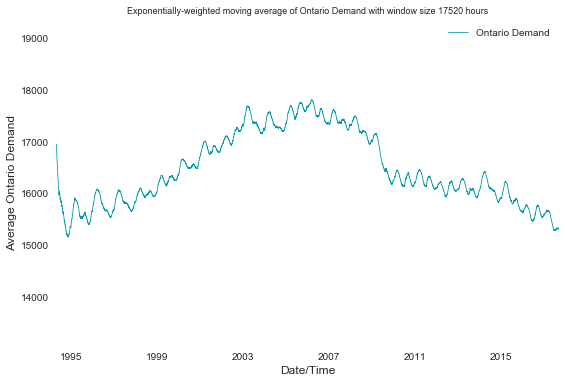

In [40]:
# Exponentially-weighted moving average
# Compute the moving average with different window sizes.
window_sizes = [24,164,740,8760,17520]
# Plot the moving average for each window size.
for win in window_sizes:
    demand_roll=df_rolling.rolling(window = win).mean()
    demand_exp=pd.ewma(df_rolling['Ontario Demand'], span = win)
    fig,ax = plt.subplots(figsize=(9,6))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.plot(df_rolling.index, demand_exp, color='#0199A3', linewidth=0.8,label="Ontario Demand")
    plt.xlabel("Date/Time", fontsize=12)
    plt.ylabel("Average Ontario Demand", fontsize=12)
    plt.title("Exponentially-weighted moving average of Ontario Demand with window size "+str(win)+" hours", fontsize=9)
    plt.xlim(["1994-05-01","2017-08-31"])
    plt.legend()
    plt.show()

The exponential model produces exhibits a much more gradual decline in energy demand after 2007 which more subtle fluctuations. We do not display the first few months due to the extreme values obatined in the beginning by considering exponential moving averages. 

# Missing values
Our data is somewhat messy with a lot of missing data. We need to find a way to replace the missing data with 
a reasonable guess.

First we remove the columns that are almost entirely NaN's or have letters signifying missing data.

In [41]:
missing_columns=["Data Quality","Temp Flag","Dew Point Temp Flag","Rel Hum Flag","Wind Dir Flag", "Wind Spd Flag",
                 "Visibility Flag","Stn Press Flag","Hmdx Flag","Wind Chill Flag","Date","Hour"]
df_sub=all_data.drop(missing_columns,axis=1)

We first remove the info past August 31, 2017.

In [42]:
df_sub_nosep=df_sub[df_sub["Date/Time"]<"2017-09-01"]
df_sub_nosep.sort_values(by="Date/Time").tail(5)

,Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),...,Hmdx,Wind Chill,Weather,Ontario Demand,Total Market Demand,HOEP,Imports,Exports,Ontario_pop,Toronto_pop
133699,2017-08-31 19:00:00,2017.0,8.0,31.0,19:00,15.2,3.8,47.0,NaN,NaN,...,NaN,NaN,NaN,15483.0,17559.0,1.95,628.0,2181.0,13647276.0,6538558.0
133700,2017-08-31 20:00:00,2017.0,8.0,31.0,20:00,14.4,3.6,48.0,NaN,NaN,...,NaN,NaN,NaN,16093.0,18153.0,6.11,1035.0,2162.0,13647276.0,6538558.0
133701,2017-08-31 21:00:00,2017.0,8.0,31.0,21:00,13.9,2.8,47.0,NaN,NaN,...,NaN,NaN,NaN,15537.0,17628.0,3.58,908.0,2188.0,13647276.0,6538558.0
133702,2017-08-31 22:00:00,2017.0,8.0,31.0,22:00,13.1,3.2,51.0,NaN,NaN,...,NaN,NaN,NaN,14539.0,16683.0,0.44,676.0,2188.0,13647276.0,6538558.0
133703,2017-08-31 23:00:00,2017.0,8.0,31.0,23:00,12.0,3.8,57.0,NaN,NaN,...,NaN,NaN,NaN,13349.0,15756.0,2.41,312.0,2451.0,13647276.0,6538558.0


We first use linear interpolation for the "Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Stn Press (kPa)", "Ontario Demand" and "Total Market Demand" columns when there is only one hour's worth of data missing.

In [43]:
df_sub_nosep=df_sub_nosep.sort_values(by="Date/Time").reset_index().drop("index",axis=1)
df_sub_nosep.interpolate(method='linear',limit_direction="forward",limit=1,inplace=True)

When there is more than one hour's worth of missing data we use the previous day's data for the "Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Stn Press (kPa)", "Ontario Demand" and "Total Market Demand" columns.

In [44]:
#List the indices where the temperature data is missing.
index_list_temp=df_sub_nosep[df_sub_nosep["Temp (°C)"].isnull()].index
# Replace the missing temperature, dew point temperature and relative humidity data with the previous day's data.
for i in index_list_temp:
    df_sub_nosep.iloc[i,5]=df_sub_nosep.iloc[i-24,5]
    df_sub_nosep.iloc[i,6]=df_sub_nosep.iloc[i-24,6]
    df_sub_nosep.iloc[i,7]=df_sub_nosep.iloc[i-24,7]
#List the indices where the pressure data is missing.
index_list_stn=df_sub_nosep[df_sub_nosep["Stn Press (kPa)"].isnull()].index
# Replace the missing pressure data with the previous day's data.
for i in index_list_stn:
    df_sub_nosep.iloc[i,11]=df_sub_nosep.iloc[i-24,11]
#List the indices where the demand data is missing.
index_list_ont=df_sub_nosep[df_sub_nosep["Ontario Demand"].isnull()].index
# Replace the missing demand data with the previous day's data.
for i in index_list_ont:
    df_sub_nosep.iloc[i,15]=df_sub_nosep.iloc[i-24,15]

We have the following formula for Humidex.
$${\text{Humidex}}=T_{\text{air}}+0.5555\left[6.11e^{5417.7530\left({\frac {1}{273.16}}-{\frac {1}{273.15+T_{\text{dew}}}}\right)}-10\right]$$

In [45]:
# Create a list of indices with missing "Hmdx" data
index_list_hmdx=df_sub_nosep[df_sub_nosep["Hmdx"].isnull()].index
# Replace the missing Hmdx value with the value from the formula
for i in index_list_hmdx:
    df_sub_nosep.iloc[i,12]=df_sub_nosep.iloc[i,5]+0.5555*(6.11*np.exp(5417.7530*(1/273.16-1/(273.15+df_sub_nosep.iloc[i,5])))-10).round(decimals=1)

## More Missing Values

Since the Ontario Energy Market opened in May 1, 2002, we only use data from this point onwards for the modeling section.

In [46]:
df_ml=df_sub_nosep[df_sub_nosep["Date/Time"]>"2002-05-01"].drop(["Year","Month","Day","Time",'Weather'],axis=1)

Visibility is also missing a lot of data. 

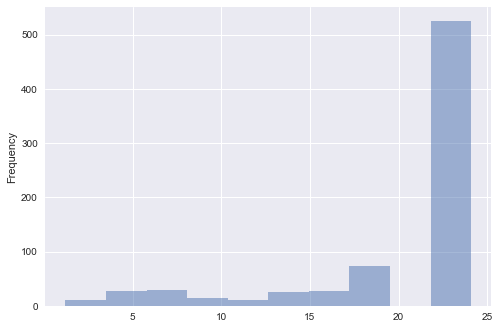

Percentage of hours with Visibility greater than 24 km: 70.56451612903226


In [47]:
df_ml["Visibility (km)"].plot.hist(alpha=0.5)
plt.show()
print("Percentage of hours with Visibility greater than 24 km:",len(df_ml[df_ml["Visibility (km)"]>24])/len(df_ml[df_ml["Visibility (km)"].notnull()])*100)

We see that 70% of the values for visibility are 24.1 km, so we replace the missing values with this value.

In [48]:
df_ml[["Visibility (km)"]]=df_ml[["Visibility (km)"]].fillna(24.1)

Now look at wind speed and wind direction.

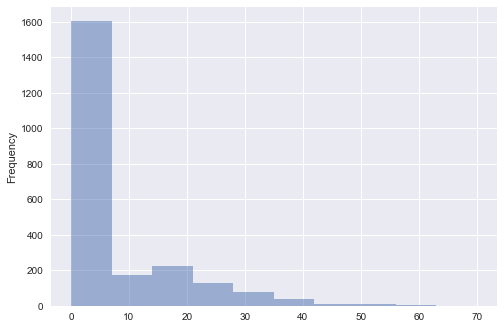

Percentage of hours with Wind Speed less than 1 km/h: 68.11977102597974
Average Wind Direction: 22.224324324324325 (10s deg)


In [49]:
df_ml["Wind Spd (km/h)"].plot.hist(alpha=0.5)
plt.show()
print("Percentage of hours with Wind Speed less than 1 km/h:",len(df_ml[df_ml["Wind Spd (km/h)"]<1])/len(df_ml[df_ml["Wind Spd (km/h)"].notnull()])*100)
print("Average Wind Direction:", df_ml["Wind Dir (10s deg)"].mean(),"(10s deg)")

Here 68% of the values for wind speed are 0 km/h so we replace the missing values with 0 km/h and for the wind direction, we replace the missing values with the mean.

In [50]:
df_ml[["Wind Spd (km/h)"]]=df_ml[["Wind Spd (km/h)"]].fillna(0)
df_ml[["Wind Dir (10s deg)"]]=df_ml[["Wind Dir (10s deg)"]].fillna(22.2)
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134447 entries, 73009 to 207455
Data columns (total 17 columns):
Date/Time              134447 non-null datetime64[ns]
Temp (°C)              134447 non-null float64
Dew Point Temp (°C)    134447 non-null float64
Rel Hum (%)            134447 non-null float64
Wind Dir (10s deg)     134447 non-null float64
Wind Spd (km/h)        134447 non-null float64
Visibility (km)        134447 non-null float64
Stn Press (kPa)        134447 non-null float64
Hmdx                   134447 non-null float64
Wind Chill             2 non-null float64
Ontario Demand         134447 non-null float64
Total Market Demand    134447 non-null float64
HOEP                   134447 non-null float64
Imports                134447 non-null float64
Exports                134447 non-null float64
Ontario_pop            134447 non-null float64
Toronto_pop            134447 non-null float64
dtypes: datetime64[ns](1), float64(16)
memory usage: 18.5 MB


We see that there is no missing values except for Wind Chill. Since there is only data for two hours, we drop this variable in our modeling step.

# Machine Learning Section

In [51]:
# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We first write the program to split the data into training and test sets, perform cross-validation, gridsearch and accuracy prediction.

In [52]:
def do_regression(model, df, parameters, featurenames, targetname, seed = 7):
    # Create the 'X' and 'y' datasets
    X=df[featurenames].values
    y=df[targetname].values
    # Split X and y into training and test data.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=seed)
    model = model()
    # Now implement GridSearchCV
    grid_model = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=1)
    # Fit the training data to find the best estimator.
    grid_model.fit(Xtrain, ytrain)
    grid_est=grid_model.best_estimator_
    print("BEST PARAMS", grid_model.best_params_)
    # Now perform K-Fold Cross-Validation on model with tuned parameters to test for over-fitting
    kf_total = KFold(n_splits=5,shuffle=True, random_state=seed)
    for train, test in kf_total.split(X): # split data into train/test groups, 5 times
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        model_fitted = grid_est.fit(X_train,y_train)
        fold_score=model_fitted.score(X_test,y_test)
        print("Cross-validation score: ", fold_score)
    # Now use the best model to find the accuracy on the test data
    training_accuracy = grid_est.score(Xtrain, ytrain)
    test_accuracy = grid_est.score(Xtest, ytest)
    print("")
    print("Accuracy on training data: {:0.5f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
    # Compare prediction with the test data
    test_prediction=grid_est.predict(Xtest)
    print("")
    print("Explained variance score: ",explained_variance_score(ytest,test_prediction))
    print("R^2 variance weighted: ",r2_score(ytest, test_prediction, multioutput='variance_weighted'))
    print("Mean absolute error: ",mean_absolute_error(ytest, test_prediction))
    print("Mean squared error: ",mean_squared_error(ytest, test_prediction))
    print("Median absolute error: ",median_absolute_error(ytest, test_prediction))
    return grid_est

## Linear Regression

We use multiple linear regression as a first attempt to model the relationship between the feature variables and the target variable "Ontario Demand" by fitting a linear equation to the observed data.

In [53]:
feature_cols=["Temp (°C)","Dew Point Temp (°C)","Rel Hum (%)", "Wind Dir (10s deg)","Wind Spd (km/h)", "Visibility (km)","Stn Press (kPa)","Hmdx", "HOEP","Imports","Exports", "Ontario_pop","Toronto_pop"]
from sklearn.linear_model import LinearRegression
params={"fit_intercept":[True,False],"normalize":[True,False]}
linear_reg=do_regression(LinearRegression,df_ml,params,feature_cols,"Ontario Demand",7)
pd.DataFrame({"feature":feature_cols,"linear_coefficient":linear_reg.coef_})

BEST PARAMS {'fit_intercept': True, 'normalize': False}
Cross-validation score:  0.431730111534
Cross-validation score:  0.410272147805
Cross-validation score:  0.415342265132
Cross-validation score:  0.417448367317
Cross-validation score:  0.405793536247

Accuracy on training data: 0.41234
Accuracy on test data:     0.43334

Explained variance score:  0.433354188087
R^2 variance weighted:  0.433335793597
Mean absolute error:  1571.2131256
Mean squared error:  3887477.3689
Median absolute error:  1348.18428583


,feature,linear_coefficient
0,Temp (°C),-28.310027
1,Dew Point Temp (°C),141.622212
2,Rel Hum (%),-52.420818
3,Wind Dir (10s deg),17.384732
4,Wind Spd (km/h),-17.954755
5,Visibility (km),-57.653193
6,Stn Press (kPa),-281.346488
7,Hmdx,-96.636208
8,HOEP,31.238758
9,Imports,1.292662


Here we find that the atmospheric pressure is the most important feature with a linear_coefficient of -281, which implies that a very small drop in atmospheric pressure gives a significant increase in energy demand. The most important feature which correspongs to a positive relationship with energy demand is Dew Point Temperature with a value of 141.622.

From above we see that several features have a very small magnitude. We now perform the KBest feature selection method by computing the ANOVA F-value for the data to reduce the number of features to the 5 most important features.

In [54]:
def feature_selection_regression(model, X,y, parameters, seed = 7):
    # Split X and y into training and test data.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=seed)
    model = model()
    # Now implement GridSearchCV
    grid_model = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=1)
    # Fit the training data to find the best estimator.
    grid_model.fit(Xtrain, ytrain)
    grid_est=grid_model.best_estimator_
    training_accuracy = grid_est.score(Xtrain, ytrain)
    test_accuracy = grid_est.score(Xtest, ytest)
    print("Accuracy on training data: {:0.5f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
    # Compare prediction with the test data
    test_prediction=grid_est.predict(Xtest)
    print("")
    print("Explained variance score: ",explained_variance_score(ytest,test_prediction))
    print("R^2 variance weighted: ",r2_score(ytest, test_prediction, multioutput='variance_weighted'))
    print("Mean absolute error: ",mean_absolute_error(ytest, test_prediction))
    print("Mean squared error: ",mean_squared_error(ytest, test_prediction))
    print("Median absolute error: ",median_absolute_error(ytest, test_prediction))
    return grid_est

In [55]:
X=df_ml[feature_cols].values
y=df_ml["Ontario Demand"].values
# feature extraction
test = SelectKBest(score_func=f_regression, k=5)
pd.DataFrame({"feature":feature_cols,"fit scores":test.fit(X,y).scores_}).sort_values(by="fit scores",ascending=False)

,feature,fit scores
8,HOEP,58857.732533
9,Imports,33887.133287
12,Toronto_pop,12519.637895
11,Ontario_pop,12423.649075
10,Exports,10770.468481
2,Rel Hum (%),2655.317701
1,Dew Point Temp (°C),1316.757139
7,Hmdx,488.971313
0,Temp (°C),352.433169
6,Stn Press (kPa),76.618296


This tells us the five most important features are "HOEP", "Imports", "Toronto_pop", "Ontario_pop" and "Exports". We perform another linear regression with only these features.

In [56]:
red_feature_cols=["HOEP","Imports","Exports", "Ontario_pop","Toronto_pop"]
X_fit = test.fit_transform(X, y)
params={"fit_intercept":[True],"normalize":[False]}
l_feat=feature_selection_regression(LinearRegression, X_fit,y, params, seed = 7)
pd.DataFrame({"feature":red_feature_cols,"linear_coefficient":l_feat.coef_})

Accuracy on training data: 0.38705
Accuracy on test data:     0.40435

Explained variance score:  0.404374453919
R^2 variance weighted:  0.404348821398
Mean absolute error:  1621.93793547
Mean squared error:  4086336.22948
Median absolute error:  1408.61198093


,feature,linear_coefficient
0,HOEP,30.519152
1,Imports,1.344129
2,Exports,-0.440662
3,Ontario_pop,-0.004646
4,Toronto_pop,0.007259


We see that with this reduced feature set that we obtain a model with a similar degree of accuracy and value of $R^2$ with much smaller coefficients in our linear model. 

## Ridge Regression
Ridge Regression is a regularization technique taken to alleviate multicollinearity amongst regression predictor variables in a model. Often predictor variables used in a regression are highly correlated. When they are, the regression coefficient of any one variable depend on which other predictor variables are included in the model, and which ones are left out.

Ridge Regression:
- Performs L2 regularization, i.e. adds penalty equivalent to square of the magnitude of coefficients
- Minimization objective = LS Obj + α * (sum of square of coefficients)

In [57]:
from sklearn.linear_model import Ridge
params={ "alpha":[0.001,0.01,0.1,1,10], "fit_intercept":[True,False],"normalize":[True,False]}
linear_ridge=do_regression(Ridge,df_ml,params,feature_cols,"Ontario Demand",7)
pd.DataFrame({"feature":feature_cols,"linear_coefficient":linear_ridge.coef_})

BEST PARAMS {'alpha': 10, 'fit_intercept': True, 'normalize': False}
Cross-validation score:  0.431730011569
Cross-validation score:  0.410272140442
Cross-validation score:  0.415342177744
Cross-validation score:  0.417448500439
Cross-validation score:  0.405793668028

Accuracy on training data: 0.41234
Accuracy on test data:     0.43334

Explained variance score:  0.433354132951
R^2 variance weighted:  0.433335737846
Mean absolute error:  1571.21393675
Mean squared error:  3887477.75136
Median absolute error:  1348.18627754


,feature,linear_coefficient
0,Temp (°C),-28.276059
1,Dew Point Temp (°C),141.582117
2,Rel Hum (%),-52.411085
3,Wind Dir (10s deg),17.376667
4,Wind Spd (km/h),-17.948919
5,Visibility (km),-57.628571
6,Stn Press (kPa),-281.296957
7,Hmdx,-96.632535
8,HOEP,31.238742
9,Imports,1.292662


Ridge regression results in the exact same model as regular linear regression. Since we do not have a problem with overfitting, this model is less useful.

## Ridge Lasso Regression

Lasso regression is a regularization technique similar to ridge regression. It differs in how it assigns a penalty to the coefficients. 

Lasso Regression:
- Performs L1 regularization, i.e. adds penalty equivalent to absolute value of the magnitude of coefficients
- Minimization objective = LS Obj + α * (sum of absolute value of coefficients)

In [58]:
from sklearn.linear_model import Lasso
params={ "alpha":[1,10], "fit_intercept":[True,False],"normalize":[True,False]}
linear_lasso=do_regression(Lasso,df_ml,params,feature_cols,"Ontario Demand",7)
pd.DataFrame({"feature":feature_cols,"linear_coefficient":linear_lasso.coef_})

BEST PARAMS {'alpha': 1, 'fit_intercept': True, 'normalize': False}
Cross-validation score:  0.431197216467
Cross-validation score:  0.409873339043
Cross-validation score:  0.415486588087
Cross-validation score:  0.416926705634
Cross-validation score:  0.405486535402

Accuracy on training data: 0.41206
Accuracy on test data:     0.43283

Explained variance score:  0.432843477812
R^2 variance weighted:  0.43282567953
Mean absolute error:  1572.4128205
Mean squared error:  3890976.89625
Median absolute error:  1349.43204251


,feature,linear_coefficient
0,Temp (°C),-22.845758
1,Dew Point Temp (°C),136.027573
2,Rel Hum (%),-50.855280
3,Wind Dir (10s deg),14.117520
4,Wind Spd (km/h),-16.299038
5,Visibility (km),-51.479483
6,Stn Press (kPa),-279.357388
7,Hmdx,-96.700147
8,HOEP,31.278000
9,Imports,1.275455


Ridge Lasso Regression results in a very similar model to regular Linear regression with a very slightly worse accuracy and value of $R^2$.

## Elastic Net
Elastic net regression is a hybrid regularization approach that blends both penalization of the L2 and L1 norms.

In [59]:
from sklearn.linear_model import ElasticNet
params={ "alpha":[1,5,10], "fit_intercept":[True,False],"normalize":[True,False]}
linear_enet=do_regression(ElasticNet,df_ml,params,feature_cols,"Ontario Demand",7)
pd.DataFrame({"feature":feature_cols,"linear_coefficient":linear_enet.coef_})

BEST PARAMS {'alpha': 1, 'fit_intercept': True, 'normalize': False}
Cross-validation score:  0.429025253658
Cross-validation score:  0.40747477137
Cross-validation score:  0.413694923083
Cross-validation score:  0.415265367715
Cross-validation score:  0.403858465394

Accuracy on training data: 0.41018
Accuracy on test data:     0.43070

Explained variance score:  0.430718316723
R^2 variance weighted:  0.43069909604
Mean absolute error:  1577.66129126
Mean squared error:  3905565.86286
Median absolute error:  1357.18947279


,feature,linear_coefficient
0,Temp (°C),15.618994
1,Dew Point Temp (°C),63.215720
2,Rel Hum (%),-32.814576
3,Wind Dir (10s deg),4.112918
4,Wind Spd (km/h),-6.068595
5,Visibility (km),-17.381072
6,Stn Press (kPa),-146.991377
7,Hmdx,-72.310048
8,HOEP,31.195987
9,Imports,1.277989


With an Elastic Net model we obtain a model with slightly worse accuracy and value of $R^2$. However the coefficients of Dew Point Temperature, Stn Pressure and Hmdx are now smaller in magnitude, while the coefficient for HOEP is quite similar to the models above. Oe difference is that Temperature now shows a positive relationship with energy demand.

## Random Forest Regressor
A random forest is an ensemble method that fits a number of decision tree regressors on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control for over-fitting.

In [60]:
from sklearn.ensemble import RandomForestRegressor
params={'n_estimators':[250,500],'max_depth':[3,5]}
rf_model=do_regression(RandomForestRegressor,df_ml,params,feature_cols,"Ontario Demand",7)
pd.DataFrame({"feature":feature_cols,"feature_importance":rf_model.feature_importances_})

BEST PARAMS {'max_depth': 5, 'n_estimators': 250}
Cross-validation score:  0.625705172055
Cross-validation score:  0.623117919097
Cross-validation score:  0.627250207887
Cross-validation score:  0.621274078512
Cross-validation score:  0.628524171695

Accuracy on training data: 0.62674
Accuracy on test data:     0.62699

Explained variance score:  0.626991211143
R^2 variance weighted:  0.62699059551
Mean absolute error:  1291.5292044
Mean squared error:  2558950.43652
Median absolute error:  1110.84794774


,feature,feature_importance
0,Temp (°C),0.170065
1,Dew Point Temp (°C),0.003373
2,Rel Hum (%),0.000017
3,Wind Dir (10s deg),0.000000
4,Wind Spd (km/h),0.000000
5,Visibility (km),0.000000
6,Stn Press (kPa),0.000412
7,Hmdx,0.042255
8,HOEP,0.710641
9,Imports,0.044229


With the Random Forest regression we see a large increase in the value of $R^2$ with an accuracy of 63%. For this model price is by far the most important feature followed by temperature. There are many features with a very low importance so we run the model again with the 5 best features chosen previously. 

In [61]:
params={'n_estimators':[500],'max_depth':[5]}
rf_feat=feature_selection_regression(RandomForestRegressor, X_fit,y, params, seed = 7)
pd.DataFrame({"feature":red_feature_cols,"linear_coefficient":rf_feat.feature_importances_})

Accuracy on training data: 0.57509
Accuracy on test data:     0.57092

Explained variance score:  0.570923102179
R^2 variance weighted:  0.570917131334
Mean absolute error:  1369.63395142
Mean squared error:  2943630.32369
Median absolute error:  1160.71675422


,feature,linear_coefficient
0,HOEP,0.842557
1,Imports,0.078181
2,Exports,0.009452
3,Ontario_pop,0.034983
4,Toronto_pop,0.034827


The reduced model does have a noticeable drop in accuracy with an increase in importance for all features. Although without temperature this model is less useful than the more complicated model.

## Gradient Boosted Regression

Gradient Boosting is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. 

- learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. We want to choose a relatively high learning rate.
- min_samples_split is the minimum number of samples required to split an internal node and should be around ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
- min_samples_leaf is the minimum number of samples required to be at a leaf node and is used to prevent overfitting. We choose a small value again because of imbalanced classes.
- max_depth limits the number of nodes in the tree.
- max_features is the number of features to consider when looking for the best split. A general rule of thumb is to start with square root.

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'learning_rate':[0.05,0.1,0.2],'n_estimators':[50,100,200],'max_depth':[3,5],'min_samples_leaf':[50],'max_features':['sqrt']}
gbr_model=do_regression(GradientBoostingRegressor,df_ml,params,feature_cols,"Ontario Demand",7)
pd.DataFrame({"feature":feature_cols,"feature_importance":gbr_model.feature_importances_})

BEST PARAMS {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'n_estimators': 200}
Cross-validation score:  0.826640027647
Cross-validation score:  0.820863517011
Cross-validation score:  0.826351538216
Cross-validation score:  0.821914968466
Cross-validation score:  0.829185982054

Accuracy on training data: 0.83475
Accuracy on test data:     0.83746

Explained variance score:  0.837456697856
R^2 variance weighted:  0.837455744722
Mean absolute error:  827.276040232
Mean squared error:  1115099.74813
Median absolute error:  676.735652092


,feature,feature_importance
0,Temp (°C),0.064861
1,Dew Point Temp (°C),0.036203
2,Rel Hum (%),0.029785
3,Wind Dir (10s deg),0.000600
4,Wind Spd (km/h),0.000589
5,Visibility (km),0.000343
6,Stn Press (kPa),0.045870
7,Hmdx,0.054143
8,HOEP,0.113818
9,Imports,0.074549


With the Gradient Boosting model we see a very large increase in accuracy again from the standard random forest regression model. The value of $R^2$ now has an accuracy of 83.7%. From our cross-validation step it does not seem to be that the model is over-fitting. the other big change is that Ontario population and Toronto population are now the two most important features with price being significantly reduced and temperature also reduced. This is somewhat surprising since there did not seem to be much correlation between the steady increase in population and the slight decline in energy demand over time.

In [63]:
parmas={'learning_rate':[0.2],'n_estimators':[200],'max_depth':[5],'min_samples_leaf':[50],'max_features':['sqrt']}
gb_feat=feature_selection_regression(GradientBoostingRegressor, X_fit,y, params, seed = 7)
pd.DataFrame({"feature":red_feature_cols,"linear_coefficient":gb_feat.feature_importances_})

Accuracy on training data: 0.83658
Accuracy on test data:     0.82140

Explained variance score:  0.821398769084
R^2 variance weighted:  0.821397732157
Mean absolute error:  860.168154603
Mean squared error:  1225262.27425
Median absolute error:  699.842879166


,feature,linear_coefficient
0,HOEP,0.144652
1,Imports,0.079857
2,Exports,0.063532
3,Ontario_pop,0.351357
4,Toronto_pop,0.360602


We perform the Gradient Boosting model on the reduced dataset and we find that the value of $R^2$ decreases only slightly to 82%. This seems to be an acceptable tradeoff between model complexity and model accuracy. Although the lack of a clear relationship between population and energy demand seems confusing, especially since the hourly population growth was obtained through a simple linear interpolation.

# Conclusion

From our investigation into energy demand, we saw a surprising effect of the introduction of energy production in Ontario to the market in 2002. Demand for energy initally increased and has been declining slightly since 2005, while average monthly exports has been steadily increasing. Along with the expected daily and weekly energy trends, energy demand exhibits clear seasonal trends that were evident in the non-linear relationship between energy and temperature. 

The best performing models were the Random Forest Regressor and Gradient Boosted Regression with $R^2$ values of 63% and 83% respectively. Note, that in the case of the GBM regression model, using feature selection to reduce the number of features resulted in a very small reduction in $R^2$. The most important features differened quite a lot between the two models with price playing a much more important role in the random forest model whereas population played a very important role in the GBM model, temperature played only a much smaller role than expected, possibly due to its non-linear relationship with energy demand. 

In the future it would be nice to incorporate more economic features like whether the economy is in a recession or a boom, housing and oil prices as well as emplyment data to see how these features are related to energy demand.